# Projeto de Previsão de Acidente Vascular Cerebral (AVC) com Python

Este notebook realiza a análise completa para a construção e avaliação de um modelo preditivo de AVC, seguindo a rubrica de Machine Learning para a área da saúde.

# Tarefa Um: Importação de dados e pré-processamento de dados

O objetivo é limpar os dados, tratar os valores ausentes e entender as relações entre as variáveis.

## 1 - Carregar dados e instalar pacotes

In [27]:
# Importação das bibliotecas essenciais para Ciência de Dados em Python

# Pandas: A biblioteca principal para carregar, manipular e limpar dados (nosso 'tidyverse' do Python)
import pandas as pd 
# NumPy: Usado para operações numéricas e arrays
import numpy as np 
# Matplotlib/Seaborn: Usados para visualização de dados (criação de gráficos). Seaborn é ótimo para estatística.
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: É a biblioteca padrão para Machine Learning em Python
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define o caminho do arquivo
file_path = '../data/healthcare-dataset-stroke-data.csv'

# Lê o arquivo CSV para um DataFrame do Pandas (df)
df = pd.read_csv(file_path)

# Mostra as primeiras 5 linhas para verificar se o carregamento funcionou
print("--- Primeiras 5 linhas do Dataset ---")
display(df.head())

--- Primeiras 5 linhas do Dataset ---


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2 - Descreva e explore os dados

In [28]:
# Remove a coluna 'id' imediatamente se ela existir, embora tenhamos confirmado que ela não existe.
# O bloco 'try/except' garante que o código não quebre se a coluna não for encontrada (boa prática!)
try:
    df = df.drop('id', axis=1)
except KeyError:
    print("A coluna 'id' não foi encontrada, seguindo com o DataFrame original.")

# --- EXPLORAÇÃO INICIAL: Estrutura e Tipos de Dados ---
print("--- Estrutura e Tipos de Dados ---")
# .info() fornece um resumo: número de linhas, colunas e, o mais importante,
# o tipo de dado de cada coluna (float, int, object) e a contagem de valores não-nulos.
df.info()

# --- VERIFICAÇÃO DE VALORES AUSENTES (NA) ---
# O .isnull() verifica onde há NA (retorna True/False) e .sum() soma quantos há por coluna
print("\n--- Contagem de Valores Ausentes (NA) ---")
print(df.isnull().sum())

--- Estrutura e Tipos de Dados ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB

--- Contagem de Valores Ausentes (NA) ---
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
wo

## 3 - Limpeza e Imputação de Dados

Esta seção aborda o tratamento dos valores ausentes (NaN) encontrados na coluna 'bmi' e a limpeza final dos dados antes da Análise Exploratória (EDA).

In [29]:
# --- 1. TRATAMENTO DO BMI (IMPUTAÇÃO) ---

# Raciocínio: Usamos a Mediana pois é mais robusta (menos afetada por outliers) que a Média.
median_bmi = df['bmi'].median(skipna=True)

print(f"Mediana de BMI a ser usada na imputação: {median_bmi:.2f}")

# Preenche (imputa) os valores ausentes (NaN) na coluna 'bmi' com a mediana calculada.
df['bmi'] = df['bmi'].fillna(median_bmi)

# --- 2. TRATAMENTO DE VARIÁVEIS CATEÓRICAS RARA ---

# Na coluna 'gender', o valor 'Other' é extremamente raro (apenas 1 caso) e pode causar problemas
# de modelo. Vamos removê-lo.
df = df[df['gender'] != 'Other']

# --- 3. RE-VERIFICAÇÃO ---
# Confirma se todos os NAs foram tratados e se a linha 'Other' foi removida.

print("\n--- Contagem de Valores Ausentes (NA) após Imputação ---")
print(df.isnull().sum())
print("\nDimensões do Dataset após limpeza:")
print(df.shape)

Mediana de BMI a ser usada na imputação: 28.10

--- Contagem de Valores Ausentes (NA) após Imputação ---
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Dimensões do Dataset após limpeza:
(5109, 11)


## 3.1 - Análise Exploratória de Dados (EDA): Visualizações

A EDA visa identificar as características clínicas e/ou do paciente mais importantes na previsão de AVC, usando a variável alvo 'stroke'.

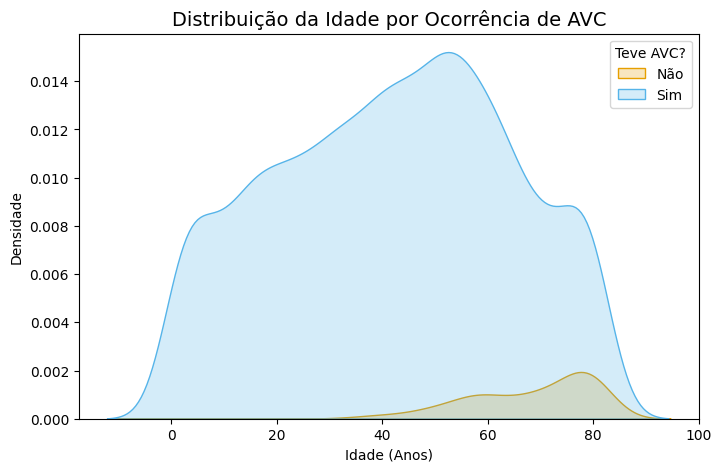

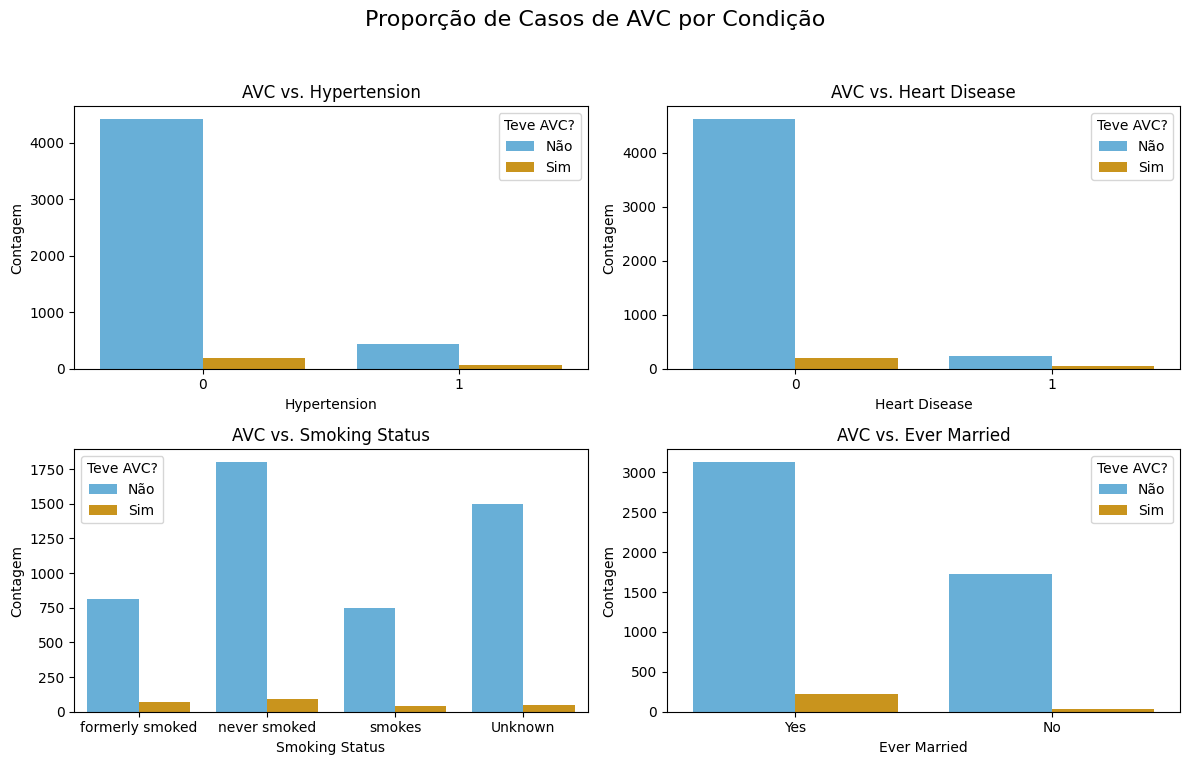

In [30]:
# --- VISUALIZAÇÃO 1: Relação entre Idade e AVC (stroke) ---

plt.figure(figsize=(8, 5))
# kde=True cria o gráfico de densidade para comparar as distribuições
sns.kdeplot(data=df, x='age', hue='stroke', fill=True, palette={0: '#56B4E9', 1: '#E69F00'})
plt.title('Distribuição da Idade por Ocorrência de AVC', fontsize=14)
plt.xlabel('Idade (Anos)')
plt.ylabel('Densidade')
plt.legend(title='Teve AVC?', labels=['Não', 'Sim'])
plt.show()

# --- VISUALIZAÇÃO 2: Risco de AVC por Fatores Categóricos ---

# Cria gráficos de barras para comparar as proporções de AVC em variáveis chave
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Proporção de Casos de AVC por Condição', fontsize=16)

# Variáveis para plotar (hypertension e heart_disease são binárias, smoking_status e ever_married são categóricas)
categorical_cols = ['hypertension', 'heart_disease', 'smoking_status', 'ever_married']

for i, col in enumerate(categorical_cols):
    row = i // 2
    col_ = i % 2
    
    # Cria a contagem de casos de AVC (1) e Não-AVC (0)
    sns.countplot(data=df, x=col, hue='stroke', palette={0: '#56B4E9', 1: '#E69F00'}, ax=axes[row, col_])
    axes[row, col_].set_title(f'AVC vs. {col.replace("_", " ").title()}')
    axes[row, col_].legend(title='Teve AVC?', labels=['Não', 'Sim'])
    axes[row, col_].set_xlabel(col.replace("_", " ").title())
    axes[row, col_].set_ylabel('Contagem')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição
plt.show()

# Tarefa Dois: Construir modelos de previsão

O objetivo é preparar os dados para o aprendizado de máquina e treinar os modelos.

# 4 - Particionamento e Preparação dos Dados


Esta fase prepara os dados para o treinamento, separando-os em conjuntos de treino e teste e aplicando transformações essenciais.

### 4.1 - Divisão em Treino e Teste (Estratificada)

Separar X e y em 80% treino e 20% teste (stratify=y).

In [33]:
# 1. Limpeza Final e Separação de Variáveis
# Removendo colunas que não ajudam na previsão ou causam instabilidade (id, gender).
# O parâmetro errors='ignore' garante que não haverá erro se a coluna 'id' não for encontrada.
X = df.drop(columns=['stroke', 'id', 'gender'], errors='ignore') 
y = df['stroke'] 

# 2. Particionamento em Treino e Teste
# test_size=0.2 -> 20% para teste.
# stratify=y -> Garante a proporção correta de casos de AVC.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dimensões de Treinamento (X, y): {X_train.shape}, {y_train.shape}")
print(f"Dimensões de Teste (X, y): {X_test.shape}, {y_test.shape}")
print("\nProporção de AVC (1) no Treino:")
print(y_train.value_counts(normalize=True))

Dimensões de Treinamento (X, y): (4087, 9), (4087,)
Dimensões de Teste (X, y): (1022, 9), (1022,)

Proporção de AVC (1) no Treino:
stroke
0    0.951309
1    0.048691
Name: proportion, dtype: float64


### 4.2 - Pré-processamento Automatizado e Balanceamento (SMOTE)

Usaremos um Pipeline para garantir que as transformações de dados (padronização e One-Hot Encoding) sejam aplicadas corretamente e de forma consistente.

In [37]:
### 4.2 Pré-processamento Automatizado e Balanceamento (SMOTE)

# 1. Identificar colunas Numéricas e Categóricas
numeric_features = ['age', 'avg_glucose_level', 'bmi']
# As colunas categóricas restantes no X_train
categorical_features = ['ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']

# 2. Criar os Transformadores
numeric_transformer = StandardScaler() # Standard Scaler (Padronização)
# OneHotEncoder: Usamos drop='first' (remove a primeira categoria para evitar redundância)
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) 

# 3. Combinar os transformadores (ColumnTransformer)
# Aplica a Padronização (StandardScaler) nas numéricas e o One-Hot nas categóricas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. Aplicação do Pré-processamento nos dados de Treino
# fit_transform TREINA o pré-processador e transforma os dados de treino.
X_train_processed = preprocessor.fit_transform(X_train)

# Obter os nomes das colunas transformadas 
feature_names = list(preprocessor.get_feature_names_out())

# Converter o resultado processado para um DataFrame (essencial para o SMOTE)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)


# ----------------------------------------------------
# 5. Balanceamento de Classes (SMOTE)
# ----------------------------------------------------

# Aplica o SMOTE (Synthetic Minority Over-sampling Technique) APENAS no conjunto de treino.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_df, y_train)

print("\n--- Resultado do Balanceamento SMOTE ---")
print("Dimensões do Treino após SMOTE:", X_train_smote.shape)
print("Proporção de AVC (1) no Treino após SMOTE (DEVE SER 50%):")
print(y_train_smote.value_counts(normalize=True))


--- Resultado do Balanceamento SMOTE ---
Dimensões do Treino após SMOTE: (7776, 14)
Proporção de AVC (1) no Treino após SMOTE (DEVE SER 50%):
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


### 4.3 - Treinamento dos Modelos de Classificação

Treinar a Regressão Logística, Random Forest e XGBoost no conjunto balanceado (X_train_smote).

In [ ]:
### 4.3 - Treinamento dos Modelos de Classificação
# Dicionário para armazenar todos os modelos treinados. Isso facilita a avaliação posterior.
models = {}

# ----------------------------------------------------------------------
# 1. Regressão Logística (Logistic Regression)
# ----------------------------------------------------------------------
# Raciocínio: É um modelo linear simples. Ele nos dará um "ponto de partida" (baseline) para comparação.
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_smote, y_train_smote)
models['Logistic Regression'] = log_reg

# ----------------------------------------------------------------------
# 2. Random Forest Classifier
# ----------------------------------------------------------------------
# Raciocínio: Modelo de ensemble (muitas árvores de decisão). É muito robusto e bom em capturar relações não-lineares.
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
random_forest.fit(X_train_smote, y_train_smote)
models['Random Forest'] = random_forest

# ----------------------------------------------------------------------
# 3. XGBoost Classifier
# ----------------------------------------------------------------------
# Raciocínio: Um dos modelos mais poderosos do Machine Learning. É o nosso "candidato campeão".
# scale_pos_weight: Mesmo após o SMOTE, é bom dar um pequeno peso para a classe de AVC, otimizando a performance.
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    scale_pos_weight=(y_train_smote.value_counts()[0]/y_train_smote.value_counts()[1])
)
xgb.fit(X_train_smote, y_train_smote)
models['XGBoost'] = xgb

print("Modelos treinados com sucesso!")
print(f"Total de modelos treinados: {len(models)}")

d:\UserData\.virtualenvs\backend-SSwBoP3o\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:00:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelos treinados com sucesso!
Total de modelos treinados: 3


# Tarefa três: Avaliar e selecionar modelos de previsão.

O objetivo é testar o desempenho dos modelos treinados em dados novos (X_test) para escolher o campeão.

## 5 - Avaliação no Conjunto de Teste

Aplicar o pré-processamento (preprocessor.transform()) em X_test e gerar previsões.

In [42]:
### 5.1 Preparação do Conjunto de Teste

# 1. Aplicar o Pré-processamento nos Dados de TESTE
# Usamos 'transform' para aplicar as regras aprendidas no treino.
X_test_processed = preprocessor.transform(X_test)

# Converter o resultado para um DataFrame (para consistência)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# 2. Dicionário para armazenar as métricas de cada modelo
results = {}

print("Iniciando avaliação dos modelos no conjunto de teste...")


Iniciando avaliação dos modelos no conjunto de teste...


### 5.1 - Comparação de Métricas

Calcular Sensibilidade, Especificidade, Precisão, F1-Score e AUC para cada modelo (requisito da rubrica).

In [43]:
### 5.1 Comparação de Métricas (Sensibilidade, AUC, etc.)

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Loop através de cada modelo treinado
for name, model in models.items():
    # Previsões de Classe (0 ou 1)
    y_pred = model.predict(X_test_df)
    
    # Previsões de Probabilidade (necessário para a métrica AUC)
    y_proba = model.predict_proba(X_test_df)[:, 1] 
    
    # Calcular Métricas essenciais
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0) # Sensibilidade (Muito importante para AVC!)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba) 
    
    # Especificidade: De todos os que NÃO tiveram AVC, quantos o modelo acertou?
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Armazenar resultados
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensibilidade)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'AUC': roc_auc
    }

# Exibir a Tabela de Resultados
results_df = pd.DataFrame(results).T 

print("\n--- Tabela de Avaliação de Modelos (Ordenada por AUC) ---")
display(results_df.sort_values(by='AUC', ascending=False))


--- Tabela de Avaliação de Modelos (Ordenada por AUC) ---


,Accuracy,Precision,Recall (Sensibilidade),Specificity,F1-Score,AUC
Logistic Regression,0.729941,0.135484,0.84,0.724280,0.233333,0.837984
XGBoost,0.926614,0.209302,0.18,0.965021,0.193548,0.782922
Random Forest,0.926614,0.162162,0.12,0.968107,0.137931,0.757438


### 5.2 - Visualização e Seleção do Melhor Modelo

Criar um gráfico comparando as métricas (como você viu na prévia) e escolher o melhor modelo com base no AUC ou F1-Score.

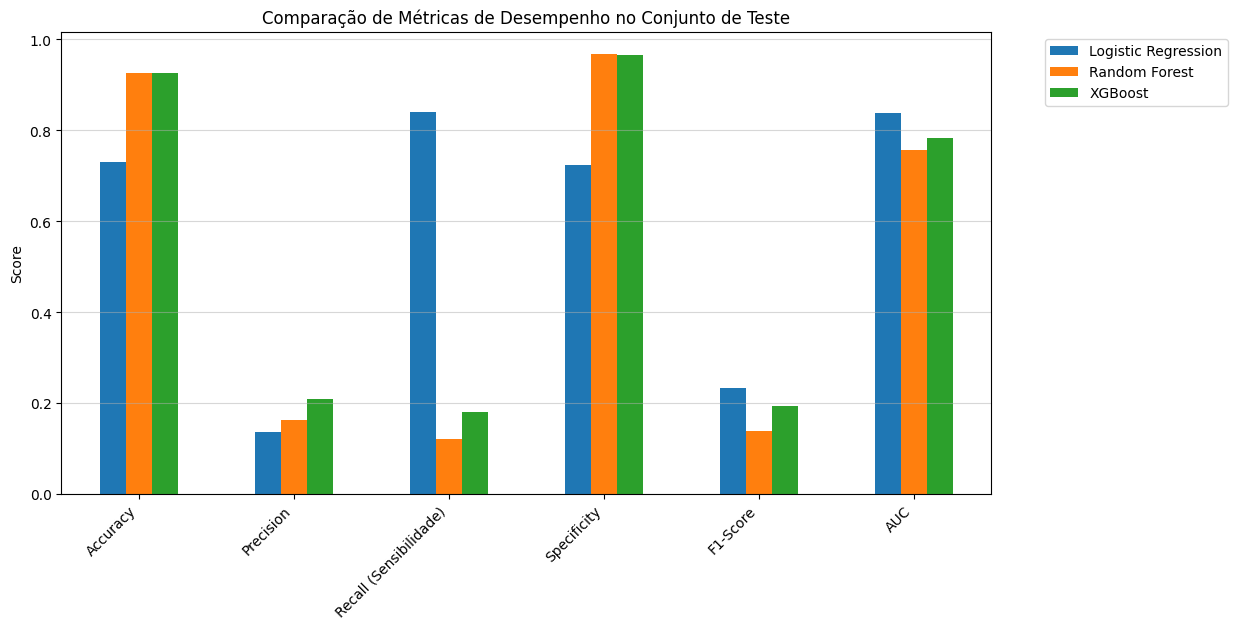


O modelo selecionado para implantação é: Logistic Regression (AUC: 0.8380)


In [44]:
### 5.2 Visualização e Seleção do Melhor Modelo

# 1. Visualizar a comparação de métricas (requisito da rubrica)
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title('Comparação de Métricas de Desempenho no Conjunto de Teste')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.5)
plt.show()

# 2. Seleção Formal do Modelo
# Escolhemos o modelo com o melhor AUC, pois mede a melhor capacidade geral de distinção.
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

print(f"\nO modelo selecionado para implantação é: {best_model_name} (AUC: {results_df['AUC'].max():.4f})")

# Tarefa Quatro: Implantar o modelo de previsão

O objetivo é demonstrar a utilidade do modelo escolhido, simulando seu uso no mundo real.

## 6 - Implementação e Salvamento do Modelo

Salvar o modelo campeão no disco (usando joblib ou pickle).

In [47]:
### 6. Salvamento do Modelo Campeão (para uso futuro)

import joblib

# Identificamos o nome do modelo com o melhor AUC
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

# Define o nome do arquivo, usando o nome do modelo para clareza
# O arquivo será salvo na pasta 'output/'
model_filename = f'../output/{best_model_name.replace(" ", "_").lower()}_stroke_model.joblib'

# Salva o modelo no disco
joblib.dump(best_model, model_filename)

# Também salvamos o pré-processador! É VITAL para transformar novos dados corretamente na hora do deploy.
preprocessor_filename = '../output/preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_filename)


print(f"Modelo Campeão ({best_model_name}) e Pré-processador salvos com sucesso no diretório 'output/'")

Modelo Campeão (Logistic Regression) e Pré-processador salvos com sucesso no diretório 'output/'


### 6.1 - Simulação de Previsão em Novo Paciente

Criar um exemplo de input e demonstrar como o modelo calcula a probabilidade de AVC (Simulação de API/Frontend).

In [48]:
### 6.1 Simulação de Previsão em Novo Paciente

# 1. Definir os dados de um novo paciente (Exemplo de Alto Risco)
new_patient_data = {
    'age': [68.0],
    'hypertension': [1],        # 1 = Tem Hipertensão
    'heart_disease': [1],       # 1 = Tem Doença Cardíaca
    'ever_married': ['Yes'],
    'work_type': ['Private'],
    'Residence_type': ['Urban'],
    'avg_glucose_level': [220.0], # Glicose alta
    'bmi': [30.0],
    'smoking_status': ['smokes']
}

# Converte os dados para o formato DataFrame (o formato esperado pelo pré-processador)
new_patient_df = pd.DataFrame(new_patient_data)


# 2. Aplicar o Pré-processador Salvo nos dados do novo paciente
# O pré-processador é aplicado APENAS com .transform()
new_patient_processed = preprocessor.transform(new_patient_df)

# Converte para DataFrame usando feature_names para garantir a ordem das colunas
new_patient_X = pd.DataFrame(new_patient_processed, columns=feature_names)


# 3. Fazer a Previsão
# Usamos o modelo campeão (best_model) para prever a probabilidade.
# [:, 1] pega a probabilidade de ter AVC (classe 1)
probability_stroke = best_model.predict_proba(new_patient_X)[:, 1][0]


# 4. Exibir o Resultado
print(f"--- Previsão de Risco para Novo Paciente ---")
print(f"Modelo Usado: {best_model_name}")
print(f"Probabilidade Calculada de AVC: {probability_stroke * 100:.2f}%")

if probability_stroke > 0.5:
    print("\nRecomendação: ALTO RISCO! Intervenção e monitoramento clínico imediato são necessários.")
else:
    print("\nRisco baixo/médio. Monitoramento e medidas preventivas são recomendadas.")

--- Previsão de Risco para Novo Paciente ---
Modelo Usado: Logistic Regression
Probabilidade Calculada de AVC: 89.60%

Recomendação: ALTO RISCO! Intervenção e monitoramento clínico imediato são necessários.


# Tarefa Cinco: Resultados e Conclusões

O objetivo é comunicar as descobertas de forma clara e profissional.

### 7 - Conclusões e Recomendações

Discutir as features mais importantes (feature_importance), as limitações do modelo e os próximos passos para a organização de saúde.